In [1]:
import numpy as np
import glob
import os
from opac_mixer.read import ReadOpacChubb
from opac_mixer.emulator import Emulator

import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown

from petitRADTRANS.poor_mans_nonequ_chem import interpol_abundances
from petitRADTRANS import nat_cst as nc
from petitRADTRANS import Radtrans
from petitRADTRANS.physics import guillot_global

%matplotlib widget

In [2]:
R='S1'
base = f'{os.environ["pRT_input_data_path"]}/opacities/lines/corr_k'
files = glob.glob(os.path.join(base,f'*_R_{R}/*.h5'))
batchsize = int(2**16)

load = True
load_model = True

In [3]:
opac = ReadOpacChubb(files)
emulator = Emulator(opac)

In [4]:
emulator.setup_sampling_grid(batchsize=batchsize, filename=f'data/input_{batchsize}', load=load)
emulator.setup_mix(filename=f'data/mix_R_{R}_{batchsize}', load=load)
emulator.setup_model(load=load_model, filename=f'data/model_R_{R}_{batchsize}')
# emulator.fit()

In [5]:
class FakeRadtrans(Radtrans):
    def calc_flux(self, temp, abunds, gravity, mmw, R_pl = None, sigma_lnorm=None,
                    fsed=None, Kzz=None, radius=None,
                    contribution=False,
                    gray_opacity=None, Pcloud=None,
                    kappa_zero=None,
                    gamma_scat=None,
                    add_cloud_scat_as_abs=None,
                    Tstar=None, Rstar=None, semimajoraxis=None,
                    geometry='dayside_ave', theta_star=0,
                    hack_cloud_photospheric_tau=None,
                    dist="lognormal", a_hans=None, b_hans=None,
                    stellar_intensity=None,
                    give_absorption_opacity=None,
                    give_scattering_opacity=None,
                    cloud_wlen=None
                    ):
        """ Method to calculate the atmosphere's emitted flux
        (emission spectrum).

            Args:
                temp:
                    the atmospheric temperature in K, at each atmospheric layer
                    (1-d numpy array, same length as pressure array).
                abunds:
                    dictionary of mass fractions for all atmospheric absorbers.
                    Dictionary keys are the species names.
                    Every mass fraction array
                    has same length as pressure array.
                gravity (float):
                    Surface gravity in cgs. Vertically constant for emission
                    spectra.
                mmw:
                    the atmospheric mean molecular weight in amu,
                    at each atmospheric layer
                    (1-d numpy array, same length as pressure array).
                R_pl: planet radius at maximum pressure in cm. If specified, the planet's changing photospheric radius
                    as function of wavelength will be calculated and saved in the self.phot_radius attribute (in cm).
                sigma_lnorm (Optional[float]):
                    width of the log-normal cloud particle size distribution
                fsed (Optional[float]):
                    cloud settling parameter
                Kzz (Optional):
                    the atmospheric eddy diffusion coeffiecient in cgs untis
                    (i.e. :math:`\\rm cm^2/s`),
                    at each atmospheric layer
                    (1-d numpy array, same length as pressure array).
                radius (Optional):
                    dictionary of mean particle radii for all cloud species.
                    Dictionary keys are the cloud species names.
                    Every radius array has same length as pressure array.
                contribution (Optional[bool]):
                    If ``True`` the emission contribution function will be
                    calculated. Default is ``False``.
                gray_opacity (Optional[float]):
                    Gray opacity value, to be added to the opacity at all
                    pressures and wavelengths (units :math:`\\rm cm^2/g`)
                Pcloud (Optional[float]):
                    Pressure, in bar, where opaque cloud deck is added to the
                    absorption opacity.
                kappa_zero (Optional[float]):
                    Scattering opacity at 0.35 micron, in cgs units (cm^2/g).
                gamma_scat (Optional[float]):
                    Has to be given if kappa_zero is definded, this is the
                    wavelength powerlaw index of the parametrized scattering
                    opacity.
                add_cloud_scat_as_abs (Optional[bool]):
                    If ``True``, 20 % of the cloud scattering opacity will be
                    added to the absorption opacity, introduced to test for the
                    effect of neglecting scattering.
                Tstar (Optional[float]):
                    The temperature of the host star in K, used only if the
                    scattering is considered. If not specified, the direct
                    light contribution is not calculated.
                Rstar (Optional[float]):
                    The radius of the star in cm. If specified,
                    used to scale the to scale the stellar flux,
                    otherwise it uses PHOENIX radius.
                semimajoraxis (Optional[float]):
                    The distance of the planet from the star. Used to scale
                    the stellar flux when the scattering of the direct light
                    is considered.
                geometry (Optional[string]):
                    if equal to ``'dayside_ave'``: use the dayside average
                    geometry. if equal to ``'planetary_ave'``: use the
                    planetary average geometry. if equal to
                    ``'non-isotropic'``: use the non-isotropic
                    geometry.
                theta_star (Optional[float]):
                    Inclination angle of the direct light with respect to
                    the normal to the atmosphere. Used only in the
                    non-isotropic geometry scenario.
                hack_cloud_photospheric_tau (Optional[float]):
                    Median optical depth (across ``wlen_bords_micron``) of the
                    clouds from the top of the atmosphere down to the gas-only
                    photosphere. This parameter can be used for enforcing the
                    presence of clouds in the photospheric region.
                dist (Optional[string]):
                    The cloud particle size distribution to use.
                    Can be either 'lognormal' (default) or 'hansen'.
                    If hansen, the b_hans parameters must be used.
                a_hans (Optional[dict]):
                    A dictionary of the 'a' parameter values for each
                    included cloud species and for each atmospheric layer,
                    formatted as the kzz argument. Equivilant to radius arg.
                    If a_hans is not included and dist is "hansen", then it will
                    be computed using Kzz and fsed (recommended).
                b_hans (Optional[dict]):
                    A dictionary of the 'b' parameter values for each
                    included cloud species and for each atmospheric layer,
                    formatted as the kzz argument. This is the width of the hansen
                    distribution normalized by the particle area (1/a_hans^2)
                give_absorption_opacity (Optional[function]):
                    A python function that takes wavelength arrays in microns and pressure arrays in bars
                    as input, and returns an absorption opacity matrix in units of cm^2/g, in the shape of
                    number of wavelength points x number of pressure points.
                    This opacity will then be added to the atmospheric absorption opacity.
                    This must not be used to add atomic / molecular line opacities in low-resolution mode (c-k),
                    because line opacities require a proper correlated-k treatment.
                    It may be used to add simple cloud absorption laws, for example, which
                    have opacities that vary only slowly with wavelength, such that the current
                    model resolution is sufficient to resolve any variations.
                stellar_intensity (Optional[array]):
                    The stellar intensity to use. If None, it will be calculated using a PHOENIX model.
                give_scattering_opacity (Optional[function]):
                    A python function that takes wavelength arrays in microns and pressure arrays in bars
                    as input, and returns an isotropic scattering opacity matrix in units of cm^2/g, in the shape of
                    number of wavelength points x number of pressure points.
                    This opacity will then be added to the atmospheric absorption opacity.
                    It may be used to add simple cloud absorption laws, for example, which
                    have opacities that vary only slowly with wavelength, such that the current
                    model resolution is sufficient to resolve any variations.
                cloud_wlen (Optional[Tuple[float, float]]):
                    Tuple with the wavelength range (in micron) that is used
                    for calculating the median optical depth of the clouds at
                    gas-only photosphere and then scaling the cloud optical
                    depth to the value of ``hack_cloud_photospheric_tau``. The
                    range of ``cloud_wlen`` should be encompassed by
                    ``wlen_bords_micron``. The full wavelength range is used
                    when ``cloud_wlen=None``.
        """

        self.hack_cloud_photospheric_tau = hack_cloud_photospheric_tau
        self.Pcloud = Pcloud
        self.kappa_zero = kappa_zero
        self.gamma_scat = gamma_scat
        self.gray_opacity = gray_opacity
        self.geometry = geometry
        self.mu_star = np.cos(theta_star * np.pi / 180.)
        self.fsed = fsed
        self.cloud_wlen = cloud_wlen

        if self.cloud_wlen is not None and (
            self.cloud_wlen[0] < 1e-4*self.lambda_angstroem[0] or
                self.cloud_wlen[1] > 1e-4*self.lambda_angstroem[-1]):
            raise ValueError('The wavelength range of cloud_wlen should '
                                'lie within the wavelength range of '
                                'self.lambda_angstroem, which is slightly '
                                'smaller than the wavelength range of '
                                'wlen_bords_micron.')

        if self.mu_star <= 0.:
            self.mu_star = 1e-8

        if stellar_intensity is None:
            self.get_star_spectrum(Tstar, semimajoraxis, Rstar)
        else:
            self.stellar_intensity = stellar_intensity

        self.interpolate_species_opa(temp)
        self.mix_opa_tot(abunds, mmw, gravity, sigma_lnorm, fsed, Kzz, radius,
                            add_cloud_scat_as_abs=add_cloud_scat_as_abs,
                            dist=dist, a_hans=a_hans, b_hans=b_hans,
                            give_absorption_opacity=give_absorption_opacity,
                            give_scattering_opacity=give_scattering_opacity)

        x_predict = np.empty((len(self.press),opac.ls+2))

        spec_names = {sp.split('_')[0]: sp for sp in self.line_species}

        for i, spec in enumerate(opac.spec):
            x_predict[:,i] = abunds[spec_names[spec]]

        x_predict[:, -2] = self.press/1e6
        x_predict[:, -1] = temp
        self.line_struc_kappas[:,:,0,:] = emulator.predict(x_predict, shape='prt', prt_freq=self.freq)

        self.line_struc_kappas[:,:,0,:] = self.line_struc_kappas[:,:,0,:] + self.continuum_opa[np.newaxis,:,:]

        self.calc_opt_depth(gravity, cloud_wlen = cloud_wlen)

        if R_pl is not None:
            raise NotImplementedError()

        if not self.skip_RT_step:
            self.calc_RT(contribution)

            if self._check_cloud_effect(abunds):
                raise NotImplementedError()

        else:
            raise NotImplementedError()

In [6]:
pressures = np.logspace(-6, 2, 100)
# pressures = chubb.pr
linespecies = [f.split('/')[-1].split('.')[0] for f in files]

atmosphere_orig = Radtrans(line_species=linespecies, pressures=pressures, wlen_bords_micron=[(1e4/opac.bin_edges).min(), (1e4/opac.bin_edges).max()], test_ck_shuffle_comp=True)
atmosphere = FakeRadtrans(line_species=linespecies, pressures=pressures, wlen_bords_micron=[(1e4/opac.bin_edges).min(), (1e4/opac.bin_edges).max()], test_ck_shuffle_comp=True)


/Users/schneider/anaconda3/envs/ml/lib/python3.10/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of NH3_R_S1...
 Done.
  Read line opacities of CO_all_iso_Chubb_R_S1...
 Done.
  Read line opacities of TiO_all_Exomol_R_S1...
 Done.
  Read line opacities of H2O_Exomol_R_S1...
 Done.
  Read line opacities of PH3_R_S1...
 Done.
  Read line opacities of VO_R_S1...
 Done.
  Read line opacities of HCN_R_S1...
 Done.
  Read line opacities of Na_allard_R_S1...
 Done.
  Read line opacities of FeH_R_S1...
 Done.
  Read line opacities of SiO_R_S1...
 Done.
  Read line opacities of K_allard_R_S1...
 Done.
  Read line opacities of CO2_R_S1...
 Done.
  Read line opacities of H2S_R_S1...
 Done.
  Read line opacities of CH4_R_S1...
 Done.

  Read line opacities of NH3_R_S1...
 Done.
  Read line opacities of CO_all_iso_Chubb_R_S1...
 Done.
  Read line opacities of TiO_all_Exomol_R_S1...
 Done.
  Read line opacities of H2O_Exomol_R_S1...
 Done.
  Read line opacities of PH3_R_S1...
 Done.
  Read line opacities of VO_R_S1...
 Done.
  Read line opacities of HCN_R_S1...
 Done.
  Re

interactive(children=(FloatSlider(value=0.4, description='gamma', max=10.0, step=0.2), FloatSlider(value=100.0…

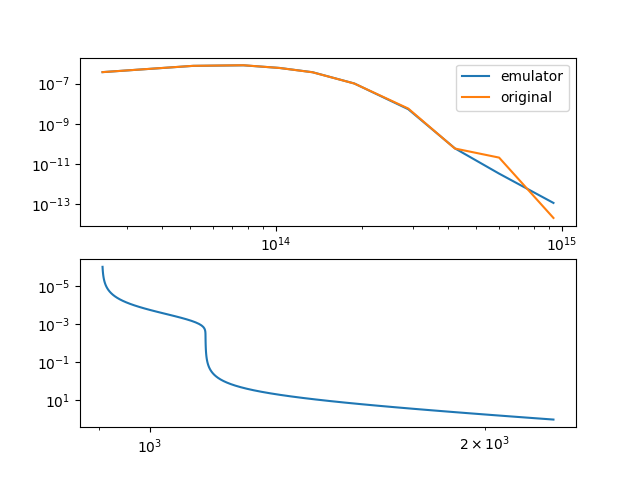

In [7]:
fig_fl, ax_fl = plt.subplots(2,1)

@interact(gamma=FloatSlider(min=0.0, max=10.0, step=0.2, value=0.4), T_int=FloatSlider(min=0.,max=1000,step=100., value=100.), T_equ=FloatSlider(min=0.,max=2000.,step=100., value=1000.))
def plot_flux(gamma, T_int, T_equ):
    for axi in ax_fl:
        axi.cla()
    
    kappa_IR = 1.0      
    Tstar=6000
    Rstar=1.0*nc.r_sun
    semimajoraxis=0.01*nc.AU
    gravity = 1e1**2.45
    geometry='dayside_ave'

    # temperature = chubb.Tr
    temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

    COs = 0.55 * np.ones_like(pressures)
    FeHs = 0. * np.ones_like(pressures)

    mass_fractions = interpol_abundances(COs, \
                FeHs, \
                temperature, \
                pressures)

    for sp in linespecies:
        mass_fractions[sp] = mass_fractions.pop(sp.split('_')[0])            

    atmosphere_orig.calc_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)
    atmosphere.calc_flux(temperature, mass_fractions, gravity, mass_fractions['MMW'], Rstar=Rstar, Tstar=Tstar, semimajoraxis=semimajoraxis, geometry=geometry)

    ax_fl[0].loglog(atmosphere.freq, atmosphere.flux, label ='emulator')
    ax_fl[0].loglog(atmosphere_orig.freq, atmosphere_orig.flux, label ='original')
    ax_fl[1].loglog(temperature, pressures)
    ax_fl[1].invert_yaxis()
    ax_fl[0].legend()
    